In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
Base = automap_base()
Base.prepare(engine, reflect=True)

C:\Users\aKost\AppData\Local\Temp\ipykernel_14092\3694105438.py:2: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
[i.__name__ for i in Base.classes]

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(func.max(Measurement.date)).scalar()

'2017-08-23'

<Figure size 6000x2400 with 0 Axes>

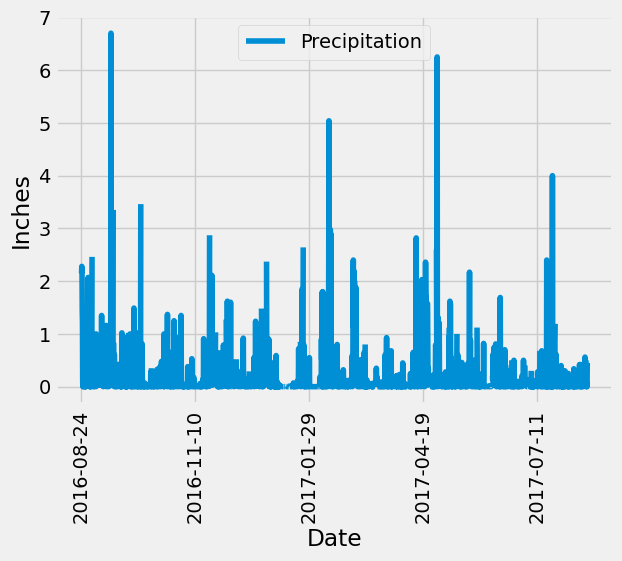

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date_dt = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date twelve months before the date of most_recent_date_dt
twelve_months_ago = most_recent_date_dt - dt.timedelta(days=365)


# Query the session for precipitation data since twelve_months_ago
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= twelve_months_ago).filter(Measurement.date <= most_recent_date_dt).all()
df_precipitation = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df_precipitation.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(60, 24))
df_precipitation.plot(x='Date', y='Precipitation', kind='line', rot=90, grid=True)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_precipitation[['Precipitation']].describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [13]:
# most active stations, queried in descending order
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# list of stations and observation counts (in descending order as queried)
for station, observation_count in most_active_stations:
    print(f"Station: {station}, Observation Count: {observation_count}")

# greatest number of observations
most_observed_station = most_active_stations[0][0]
print("\nStation with the greatest number of observations:", most_observed_station)


Station: USC00519281, Observation Count: 2772
Station: USC00519397, Observation Count: 2724
Station: USC00513117, Observation Count: 2709
Station: USC00519523, Observation Count: 2669
Station: USC00516128, Observation Count: 2612
Station: USC00514830, Observation Count: 2202
Station: USC00511918, Observation Count: 1979
Station: USC00517948, Observation Count: 1372
Station: USC00518838, Observation Count: 511

Station with the greatest number of observations: USC00519281


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_observed_station).all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]

lowest_temp, highest_temp, avg_temp

(54.0, 85.0, 71.66378066378067)

<Figure size 800x600 with 0 Axes>

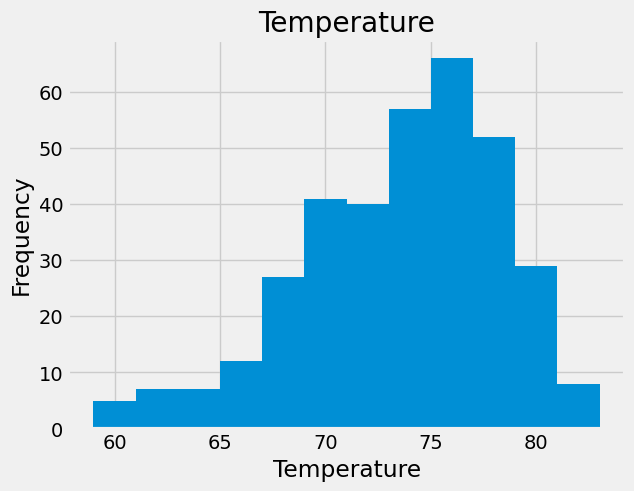

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_data = session.query(Measurement.tobs).filter(Measurement.station == most_observed_station).filter(Measurement.date >= twelve_months_ago).filter(Measurement.date <= most_recent_date_dt).all()

df_temperature = pd.DataFrame(temperature_data, columns=['Temperature'])

plt.figure(figsize=(8, 6))
df_temperature.hist(bins=12, grid=True)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [19]:
# Close Session
session.close()